In [14]:
import sys; sys.path.append('../')
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import OrderedDict
from loss import compare_activations, get_bre_loss, get_gradmask_loss
import copy
import itertools
import logging
import notebooks.auto_ipynb as auto_ipynb
import numpy as np
import pprint
import random
import time, os, sys
import torch
import torch.nn as nn
import utils.configuration as configuration
import utils.monitoring as monitoring
import models, models.CNN, models.ResNetSmall, models.UNet
import matplotlib.pyplot as plt
import datasets, datasets.MSDDataset
import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# Globals
NSAMPLES = 100

In [33]:
def render_img(text, i, sample, cnn, resnet, unet, exp_name):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=6,
                                             figsize=(18, 12), dpi=72)
    x, target, use_mask = sample
    
    x_var = torch.autograd.Variable(x[0].unsqueeze(0),
        requires_grad=True)

#     cnn.eval()
#     resnet.eval()
#     unet.eval()

    ax0.set_title(str(i) + " Masked Image")
    img = x[0][0].cpu().numpy()
    img = img / np.max(img)  # Scales the input image so that the maximum=1.
    seg = x[1][0].cpu().numpy() #* 0.5  # Makes mask bright, but not too bright.
    ax0.imshow(img, interpolation='none', cmap='Greys_r')
    ax0.axis('off')
    
    ax1.set_title("Mask")
    ax1.imshow(1-seg, cmap="Greys_r", interpolation='none')
    ax1.axis('off')

    ax2.set_title("CNN")
    y_prime, x_prime = cnn(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, cnn, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax2.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax2.axis('off')
    
    ax3.set_title("Resnet")
    y_prime, x_prime = resnet(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax3.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax3.axis('off')
    
    ax4.set_title("UNet")
    y_prime, x_prime = unet(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax4.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax4.axis('off')

    ax5.set_title("UNet Reconstruction")
    # Fails for models that output a nonsense reconstruction (CNN, ResNet).
    if isinstance(x_prime, torch.Tensor):
        ax5.imshow(x_prime[0][0].detach().cpu().numpy(),
                   interpolation='none', cmap='Greys_r')
        ax5.axis('off')
    else:
        ax5.remove()

    plt.tight_layout()
    plt.show()

    
def render_mean_grad(text, i, dataset, mdl_baseline, mdl_actdiff, mdl_gradmask, exp_name, 
                     img_size=100):
    """
    Renders the mean saliency map across all inputs in the dataset, from the
    input models for visual comparison.
    """
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5,
                                                  figsize=(18, 12), dpi=72)

    mean_img = np.zeros((img_size, img_size))
    mean_mask = np.zeros((img_size, img_size))
    mean_baseline = np.zeros((img_size, img_size))
    mean_actdiff = np.zeros((img_size, img_size))
    mean_gradmask = np.zeros((img_size, img_size))
    
    for sample in dataset:
        x, target, use_mask = sample
        x_var = torch.autograd.Variable(x[0].unsqueeze(0), requires_grad=True)
    
        mean_img += x[0].detach().cpu().numpy()[0]
        mean_mask += x[1].detach().cpu().numpy()[0]
        
        y_prime, x_prime = mdl_baseline(x_var)
        gradmask = get_gradmask_loss(x_var, y_prime, mdl_baseline, torch.tensor(1.),
                                     "contrast").detach().cpu().numpy()[0][0]
        mean_baseline += np.abs(gradmask)

        y_prime, x_prime = mdl_actdiff(x_var)
        gradmask = get_gradmask_loss(x_var, y_prime, mdl_actdiff, torch.tensor(1.),
                                     "contrast").detach().cpu().numpy()[0][0]
        mean_actdiff += np.abs(gradmask)

        y_prime, x_prime = mdl_gradmask(x_var)
        gradmask = get_gradmask_loss(x_var, y_prime, mdl_gradmask, torch.tensor(1.),
                                     "contrast").detach().cpu().numpy()[0][0]
        mean_gradmask += np.abs(gradmask)

    mean_img /= len(dataset)
    mean_mask /= len(dataset)
    mean_baseline /= len(dataset)
    mean_actdiff /= len(dataset)
    mean_gradmask /= len(dataset)
    
    ax0.set_title(str(i) + " Masked Image")
    ax0.imshow(mean_img, interpolation='none', cmap='Greys_r')
    ax0.axis('off')
    
    ax1.set_title("Mask")
    ax1.imshow(mean_mask, cmap="Greys_r", interpolation='none')
    ax1.axis('off')

    ax2.set_title("Baseline")
    ax2.imshow(mean_baseline, cmap="jet", interpolation='none')
    ax2.axis('off')
    
    ax3.set_title("Actdiff")
    ax3.imshow(mean_actdiff, cmap="jet", interpolation='none')
    ax3.axis('off')
    
    ax4.set_title("Gradmask")
    ax4.imshow(mean_gradmask, cmap="jet", interpolation='none')
    ax4.axis('off')

    plt.tight_layout()
    plt.show()
    
    
def load_resnet(model_name):
    state_dict = torch.load(model_name, map_location='cpu')
    mdl = models.ResNetSmall.ResNetSmall(base_size=4608, img_size=100)
    mdl.load_state_dict(state_dict.state_dict())
    
    return(mdl)


def load_cnn(model_name):
    state_dict = torch.load(model_name, map_location='cpu')
    mdl = models.UNet.UNet(img_size=100, nc=64, mode='cnn')
    mdl.load_state_dict(state_dict.state_dict())
    
    return(mdl)


def load_unet(model_name):
    state_dict = torch.load(model_name, map_location='cpu')
    mdl = models.UNet.UNet(img_size=100, nc=64, mode='unet')
    mdl.load_state_dict(state_dict.state_dict())
    
    return(mdl)

In [17]:
# Get available models.
available = glob.glob("/network/tmp1/vivianoj/checkpoints/*resnet*/best_model*_451_*.pth.tar")
available.sort()
available

['/network/tmp1/vivianoj/checkpoints/cardiacmsd_resnet/best_model_451_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/cardiacmsd_resnet_actdiff/best_model_451_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/cardiacmsd_resnet_actgrad/best_model_451_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/cardiacmsd_resnet_clfmasked/best_model_451_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/cardiacmsd_resnet_gradmask/best_model_451_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/livermsd_resnet/best_model_451_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/livermsd_resnet_actdiff/best_model_451_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/livermsd_resnet_actgrad/best_model_451_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/livermsd_resnet_clfmasked/best_model_451_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/livermsd_resnet_gradmask/best_model_451_1.0.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/pancreasmsd_resnet/best_model_451_1.0.pth.tar',
 '/network/tmp1

Full dataset contains: Counter({False: 17929, True: 8790})
mode=test
Loading 113 files:['pancreas_243.nii.gz', 'pancreas_191.nii.gz', 'pancreas_345.nii.gz', 'pancreas_167.nii.gz', 'pancreas_309.nii.gz', 'pancreas_158.nii.gz', 'pancreas_375.nii.gz', 'pancreas_264.nii.gz', 'pancreas_069.nii.gz', 'pancreas_193.nii.gz', 'pancreas_001.nii.gz', 'pancreas_159.nii.gz', 'pancreas_160.nii.gz', 'pancreas_366.nii.gz', 'pancreas_334.nii.gz', 'pancreas_111.nii.gz', 'pancreas_088.nii.gz', 'pancreas_087.nii.gz', 'pancreas_138.nii.gz', 'pancreas_418.nii.gz', 'pancreas_230.nii.gz', 'pancreas_046.nii.gz', 'pancreas_344.nii.gz', 'pancreas_242.nii.gz', 'pancreas_234.nii.gz', 'pancreas_126.nii.gz', 'pancreas_287.nii.gz', 'pancreas_170.nii.gz', 'pancreas_217.nii.gz', 'pancreas_374.nii.gz', 'pancreas_419.nii.gz', 'pancreas_304.nii.gz', 'pancreas_015.nii.gz', 'pancreas_110.nii.gz', 'pancreas_137.nii.gz', 'pancreas_275.nii.gz', 'pancreas_203.nii.gz', 'pancreas_229.nii.gz', 'pancreas_355.nii.gz', 'pancreas_389.n

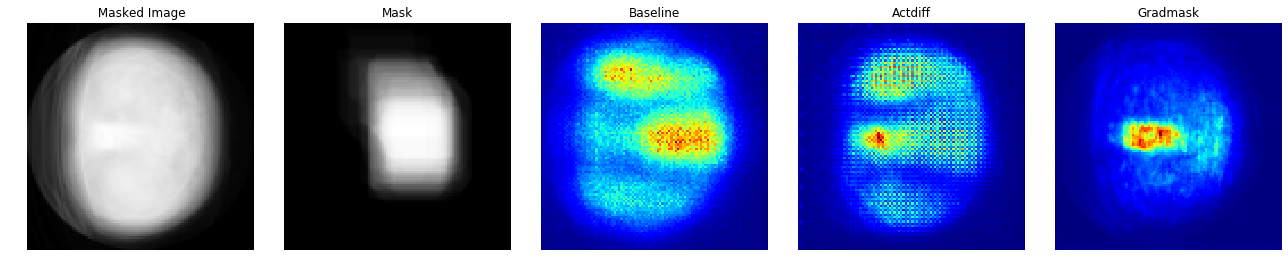

In [52]:
dataset = datasets.MSDDataset.PancreasMSDDataset(mode='test', nsamples=NSAMPLES, blur=16)
baseline = load_resnet("/network/tmp1/vivianoj/checkpoints/pancreasmsd_resnet/best_model_451_1.0.pth.tar")
actdiff = load_resnet('/network/tmp1/vivianoj/checkpoints/pancreasmsd_resnet_actdiff/best_model_451_1.0.pth.tar')
gradmask = load_resnet('/network/tmp1/vivianoj/checkpoints/pancreasmsd_resnet_gradmask/best_model_451_1.0.pth.tar')
render_mean_grad("aaa", "", dataset, baseline, actdiff, gradmask, "a")

Full dataset contains: Counter({False: 39476, True: 19162})
mode=test
Loading 53 files:['liver_49.nii.gz', 'liver_13.nii.gz', 'liver_119.nii.gz', 'liver_48.nii.gz', 'liver_126.nii.gz', 'liver_80.nii.gz', 'liver_32.nii.gz', 'liver_82.nii.gz', 'liver_83.nii.gz', 'liver_127.nii.gz', 'liver_81.nii.gz', 'liver_110.nii.gz', 'liver_63.nii.gz', 'liver_115.nii.gz', 'liver_124.nii.gz', 'liver_25.nii.gz', 'liver_79.nii.gz', 'liver_55.nii.gz', 'liver_39.nii.gz', 'liver_99.nii.gz', 'liver_52.nii.gz', 'liver_43.nii.gz', 'liver_53.nii.gz', 'liver_116.nii.gz', 'liver_93.nii.gz', 'liver_46.nii.gz', 'liver_50.nii.gz', 'liver_120.nii.gz', 'liver_14.nii.gz', 'liver_54.nii.gz', 'liver_86.nii.gz', 'liver_22.nii.gz', 'liver_89.nii.gz', 'liver_16.nii.gz', 'liver_73.nii.gz', 'liver_4.nii.gz', 'liver_33.nii.gz', 'liver_109.nii.gz', 'liver_98.nii.gz', 'liver_60.nii.gz', 'liver_44.nii.gz', 'liver_6.nii.gz', 'liver_130.nii.gz', 'liver_84.nii.gz', 'liver_117.nii.gz', 'liver_56.nii.gz', 'liver_106.nii.gz', 'liver_74

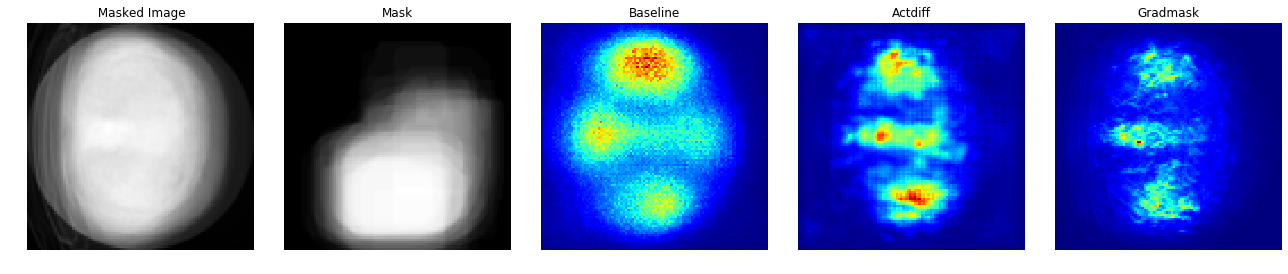

In [53]:
dataset = datasets.MSDDataset.LiverMSDDataset(mode='test', nsamples=NSAMPLES, blur=16)
baseline = load_resnet("/network/tmp1/vivianoj/checkpoints/livermsd_resnet/best_model_451_1.0.pth.tar")
actdiff = load_resnet('/network/tmp1/vivianoj/checkpoints/livermsd_resnet_actdiff/best_model_451_1.0.pth.tar')
gradmask = load_resnet('/network/tmp1/vivianoj/checkpoints/livermsd_resnet_gradmask/best_model_451_1.0.pth.tar')
render_mean_grad("aaa", "", dataset, baseline, actdiff, gradmask, "a")

Full dataset contains: Counter({True: 1351, False: 920})
mode=test
Loading 8 files:['la_017.nii.gz', 'la_014.nii.gz', 'la_024.nii.gz', 'la_019.nii.gz', 'la_007.nii.gz', 'la_003.nii.gz', 'la_023.nii.gz', 'la_020.nii.gz']
Loaded images contain:Counter({True: 540, False: 400})
This dataloader contains: Counter({False: 50, True: 50})


/network/home/vivianoj/python/python-37/envs/activmask/lib/python3.5/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'models.ResNetSmall.ResNetSmall' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/network/home/vivianoj/python/python-37/envs/activmask/lib/python3.5/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'models.ResNetSmall.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


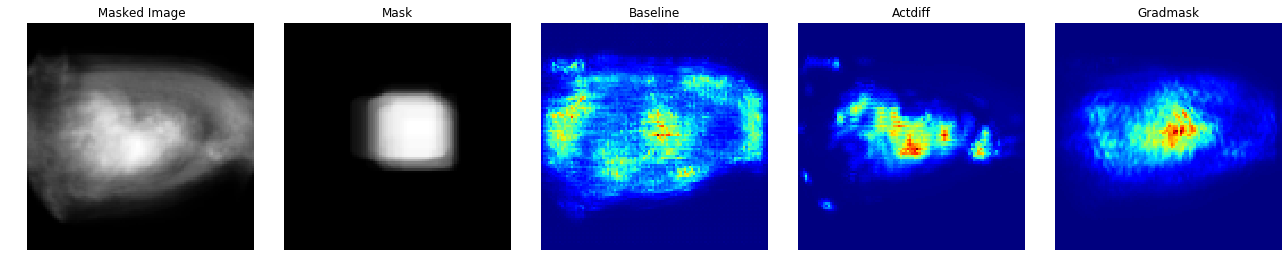

In [55]:
dataset = datasets.MSDDataset.HeartMSDDataset(mode='test', nsamples=NSAMPLES, blur=8)
baseline = load_resnet("/network/tmp1/vivianoj/checkpoints/cardiacmsd_resnet/best_model_1234_1.0.pth.tar")
actdiff = load_resnet('/network/tmp1/vivianoj/checkpoints/cardiacmsd_resnet_actdiff/best_model_1234_1.0.pth.tar')
gradmask = load_resnet('/network/tmp1/vivianoj/checkpoints/cardiacmsd_resnet_gradmask/best_model_1234_1.0.pth.tar')
render_mean_grad("aaa", "", dataset, baseline, actdiff, gradmask, "a")